# Continuum Macro-Element (CME)
Hypothesis:

In [23]:
# Init the environment
%reset -f
from mpmath import *
mp.dps = 320 #Default value is 15
mp.pretty = True #Nice matrix display
import numpy as np
from matplotlib import pyplot as plot
%matplotlib inline

# Print information of mpmath package
print(mp)

Mpmath settings:
  mp.prec = 1066              [default: 53]
  mp.dps = 320                [default: 15]
  mp.trap_complex = False     [default: False]


In [37]:
# SLJ parameters
mm=500; #point en x
nn=2; #point en y

cases = 2; # 0 : default | 1 : FEM | 2 : Nguyen2021 | 3 : Methfessel2022

# Input data for default case
f=5000;
b=25; L=25; e=0.4;
e1=2; e2=e1; l1=75; l2=l1;
Ea=6500; nua=0.36;
E1=210000; E2=E1;
nu1=0.3; nu2=nu1;

Ga=Ea/(2*(1+nua)); G1=E1/(2*(1+nu1)); G2=E2/(2*(1+nu2));
E1p=E1; nu1p=0; G1p=G1; h1=e1/2;
E2p=E2; nu2p=0; G2p=G2; h2=e2/2;
Eap=Ea/(1-nua**2); nuap=nua; Gap=Ga; ha=e/2; 
Sa=b*2*ha; S1=b*2*h1; S2=b*2*h2;

In [ ]:
# Overwrite default case for the article study case
if(cases==1): # FEM
    L = 50; l1=50; l2=l1;
    b=1; e=0.2; e1=2; e2=2;
    Ea=2500; nua=0.4; Ga=Ea/(2*(1+nua));
    E1=70000; nu1=0.35; G1=E1/(2*(1+nu1));
    E2=E1; nu2=0.35; G2=E2/(2*(1+nu2));
    f=100;
    
    E1p=E1/(1-nu1^2); nu1p=nu1/(1-nu1); h1=e1/2;
    E2p=E2/(1-nu2^2); nu2p=nu2/(1-nu2); h2=e2/2;
    Eap=Ea/(1-nua^2); nuap=nua/(1-nua); ha=e/2;
    G1p=G1;
    G2p=G2;
    Gap=Ga;
elif(cases==2): # Nguyen2021
    L = 25; l1=75; l2=l1;
    b=25; e=0.4; e1=2; e2=2;
    Ea=6500; nua=0.36; Ga=Ea/(2*(1+nua));
    E1=210000; nu1=0.3; G1=E1/(2*(1+nu1));
    E2=E1; nu2=nu1; G2=E2/(2*(1+nu2));
    f=5000;
    
    E1p=E1; nu1p=0; h1=e1/2;
    E2p=E2; nu2p=0; h2=e2/2;
    Eap=Ea/(1-nua^2); nuap=nua; ha=e/2;
    G1p=G1;5/6*G1;
    G2p=G2;5/6*G2;
    Gap=Ga;
elif(cases==3): # Methfessel2022
    L = 25; l1=50; l2=l1;
    b=25; e=0.5; e1=2; e2=2;
    Ea=2460; nua=0.4; Ga=Ea/(2*(1+nua));
    E1=210000; nu1=0.33; G1=E1/(2*(1+nu1));
    E2=E1; nu2=nu1; G2=E2/(2*(1+nu2));
    f=5000;
    
    E1p=E1/(1-nu1^2); nu1p=0; h1=e1/2;
    E2p=E2/(1-nu2^2); nu2p=0;nu2; h2=e2/2;
    Eap=Ea*(1-nua)/(1+nua)/(1-2*nua); nuap=nua/(1-nua); ha=e/2;
    G1p=5/6*G1;
    G2p=5/6*G2;
    Gap=Ga;

In [25]:
#Beam: system of ODEs to solve
A_me_beam_1=matrix(np.zeros((6,6)));
A_me_beam_1[0,3]=1; A_me_beam_1[1,4]=1; A_me_beam_1[2,5]=1;
A_me_beam_1[4,1]=G1p/E1p*3/h1**2; A_me_beam_1[4,5]=A_me_beam_1[4,1];
A_me_beam_1[5,4]=-1;

A_me_beam_2=matrix(np.zeros((6,6)));
A_me_beam_2[0,3]=1; A_me_beam_2[1,4]=1; A_me_beam_2[2,5]=1;
A_me_beam_2[4,1]=G2p/E2p*3/h2**2; A_me_beam_2[4,5]=A_me_beam_2[4,1];
A_me_beam_2[5,4]=-1;

In [26]:
#Stiffness matrix for the adherend 1 and 2
def generate_K_i(A_me_beam_i,li,hi,b,Eip,Gip):
    Y_i0=expm(A_me_beam_i*0); YY_i0=A_me_beam_i*Y_i0;
    Y_iL=expm(A_me_beam_i*li); YY_iL=A_me_beam_i*Y_iL;
    ui0_0=Y_i0[0,:]; ui1_0=Y_i0[1,:]; vi0_0=Y_i0[2,:];
    dui0_0=YY_i0[0,:]; dui1_0=YY_i0[1,:]; dvi0_0=YY_i0[2,:];
    Nixx_0 = 2 * Eip * dui0_0 * hi * b; 
    Nixy_0 = 2 * Gip * (ui1_0 + dvi0_0) * hi * b;
    Mixx1_0 = 2 / 3 * Eip * dui1_0 * hi ** 3 * b;

    ui0_L=Y_iL[0,:]; ui1_L=Y_iL[1,:]; vi0_L=Y_iL[2,:];
    dui0_L=YY_iL[0,:]; dui1_L=YY_iL[1,:]; dvi0_L=YY_iL[2,:];
    Nixx_L = 2 * Eip * dui0_L * hi * b;
    Nixy_L = 2 * Gip * (ui1_L + dvi0_L) * hi * b;
    Mixx1_L = 2 / 3 * Eip * dui1_L * hi ** 3 * b;

    Mi=matrix(np.zeros((6,6)));
    Mi[0,:]=ui0_0;
    Mi[1,:]=vi0_0;
    Mi[2,:]=ui1_0;
    Mi[3,:]=ui0_L;
    Mi[4,:]=vi0_L;
    Mi[5,:]=ui1_L;

    Ni=matrix(np.zeros((6,6)));
    Ni[0,:]=-Nixx_0;
    Ni[1,:]=-Nixy_0;
    Ni[2,:]=-Mixx1_0;
    Ni[3,:]=Nixx_L;
    Ni[4,:]=Nixy_L;
    Ni[5,:]=Mixx1_L;

    inv_Mi=inverse(Mi);
    Ki=Ni*inv_Mi;

    return inv_Mi, Ki
inv_M1, K1 = generate_K_i(A_me_beam_1,l1,h1,b,E1p,G1p)
inv_M2, K2 = generate_K_i(A_me_beam_2,l2,h2,b,E2p,G2p)


In [27]:
# CME: System of ODEs to solve
A_me_1 = matrix([[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]])
A_me_2 = matrix([[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]])
A_me_3 = matrix([[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]])
A_me_4 = matrix([[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]])
A_me_5 = matrix([[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]])
A_me_6 = matrix([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]])
A_me_7 = matrix([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]])
A_me_8 = matrix([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]])
A_me_9 = matrix([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])
A_me_10 = matrix([[-(-180 * E1p * E2p * Gap * h1 * h2 - 120 * E1p * Eap * Gap * h1 * ha - 120 * E2p * Eap * Gap * h2 * ha - 80 * Eap ** 2 * Gap * ha ** 2) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(90 * E1p * E2p * Gap * h1 * h2 + 51 * E1p * Eap * Gap * h1 * ha + 69 * E2p * Eap * Gap * h2 * ha + 40 * Eap ** 2 * Gap * ha ** 2) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-90 * E1p * E2p * Gap * h1 ** 2 * h2 - 51 * E1p * Eap * Gap * h1 ** 2 * ha - 27 * E2p * Eap * G1p * h2 * ha ** 2 - 69 * E2p * Eap * Gap * h1 * h2 * ha - 18 * Eap ** 2 * G1p * ha ** 3 - 40 * Eap ** 2 * Gap * h1 * ha ** 2) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(90 * E1p * E2p * Gap * h1 * h2 + 69 * E1p * Eap * Gap * h1 * ha + 51 * E2p * Eap * Gap * h2 * ha + 40 * Eap ** 2 * Gap * ha ** 2) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(90 * E1p * E2p * Gap * h1 * h2 ** 2 + 27 * E1p * Eap * G2p * h1 * ha ** 2 + 69 * E1p * Eap * Gap * h1 * h2 * ha + 51 * E2p * Eap * Gap * h2 ** 2 * ha + 18 * Eap ** 2 * G2p * ha ** 3 + 40 * Eap ** 2 * Gap * h2 * ha ** 2) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,0,0,0,0,0,0,0,0,0,-(-12 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap + 12 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap - 12 * E1p * Eap * Gap * h1 * ha ** 2 + 12 * E2p * Eap * Gap * h2 * ha ** 2) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(36 * E1p * E2p * Eap * h1 * h2 * ha ** 2 * nuap + 24 * E1p * Eap ** 2 * h1 * ha ** 3 * nuap + 24 * E2p * Eap ** 2 * h2 * ha ** 3 * nuap + 16 * Eap ** 3 * ha ** 4 * nuap + 36 * E1p * E2p * Gap * h1 * h2 * ha ** 2 + 24 * E1p * Eap * Gap * h1 * ha ** 3 + 24 * E2p * Eap * Gap * h2 * ha ** 3 + 16 * Eap ** 2 * Gap * ha ** 4) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(27 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 15 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap + 3 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap + 27 * E1p * E2p * Gap * h1 * h2 * ha + 15 * E1p * Eap * Gap * h1 * ha ** 2 - 27 * E2p * Eap * G1p * h2 * ha ** 2 + 21 * E2p * Eap * Gap * h2 * ha ** 2 - 18 * Eap ** 2 * G1p * ha ** 3 + 12 * Eap ** 2 * Gap * ha ** 3) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-27 * E1p * E2p * Eap * h1 * h2 * ha * nuap - 3 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap - 15 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap - 27 * E1p * E2p * Gap * h1 * h2 * ha + 27 * E1p * Eap * G2p * h1 * ha ** 2 - 21 * E1p * Eap * Gap * h1 * ha ** 2 - 15 * E2p * Eap * Gap * h2 * ha ** 2 + 18 * Eap ** 2 * G2p * ha ** 3 - 12 * Eap ** 2 * Gap * ha ** 3) / ha ** 2 / Eap / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4]])
A_me_11 = matrix([[1 / ha * (-60 * E1p * E2p * Gap * h1 * h2 - 40 * E1p * Eap * Gap * h1 * ha) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,1 / ha * (48 * E1p * E2p * Gap * h1 * h2 + 26 * E1p * Eap * Gap * h1 * ha) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,1 / ha * (-48 * E1p * E2p * Gap * h1 ** 2 * h2 - 26 * E1p * Eap * Gap * h1 ** 2 * ha + 27 * E2p * Eap * G1p * h2 * ha ** 2 + 12 * Eap ** 2 * G1p * ha ** 3) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,1 / ha * (12 * E1p * E2p * Gap * h1 * h2 + 14 * E1p * Eap * Gap * h1 * ha) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,1 / ha * (12 * E1p * E2p * Gap * h1 * h2 ** 2 + 9 * E1p * Eap * G2p * h1 * ha ** 2 + 14 * E1p * Eap * Gap * h1 * h2 * ha) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,0,0,0,0,0,0,0,0,0,1 / ha * (24 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 8 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap + 24 * E1p * E2p * Gap * h1 * h2 * ha + 8 * E1p * Eap * Gap * h1 * ha ** 2) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,1 / ha * (12 * E1p * E2p * Eap * h1 * h2 * ha ** 2 * nuap + 8 * E1p * Eap ** 2 * h1 * ha ** 3 * nuap + 12 * E1p * E2p * Gap * h1 * h2 * ha ** 2 + 8 * E1p * Eap * Gap * h1 * ha ** 3) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,1 / ha * (-21 * E1p * E2p * Eap * h1 * h2 * ha * nuap - 10 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap + 15 * E1p * E2p * Gap * h1 * h2 * ha + 8 * E1p * Eap * Gap * h1 * ha ** 2 + 27 * E2p * Eap * G1p * h2 * ha ** 2 + 12 * Eap ** 2 * G1p * ha ** 3) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4,1 / ha * (-3 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 2 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap - 3 * E1p * E2p * Gap * h1 * h2 * ha + 9 * E1p * Eap * G2p * h1 * ha ** 2 - 4 * E1p * Eap * Gap * h1 * ha ** 2) / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / h1 / E1p / 4]])
A_me_12 = matrix([[-0.3e1 / 0.4e1 * (-60 * E1p * E2p * Gap * h1 * h2 - 40 * E1p * Eap * Gap * h1 * ha) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (48 * E1p * E2p * Gap * h1 * h2 + 26 * E1p * Eap * Gap * h1 * ha) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-72 * E1p * E2p * G1p * h1 * h2 * ha - 48 * E1p * E2p * Gap * h1 ** 2 * h2 - 36 * E1p * Eap * G1p * h1 * ha ** 2 - 26 * E1p * Eap * Gap * h1 ** 2 * ha - 9 * E2p * Eap * G1p * h2 * ha ** 2 - 4 * Eap ** 2 * G1p * ha ** 3) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (12 * E1p * E2p * Gap * h1 * h2 + 14 * E1p * Eap * Gap * h1 * ha) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (12 * E1p * E2p * Gap * h1 * h2 ** 2 + 9 * E1p * Eap * G2p * h1 * ha ** 2 + 14 * E1p * Eap * Gap * h1 * h2 * ha) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),0,0,0,0,0,0,0,0,0,-0.3e1 / 0.4e1 * (24 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 8 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap + 24 * E1p * E2p * Gap * h1 * h2 * ha + 8 * E1p * Eap * Gap * h1 * ha ** 2) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (12 * E1p * E2p * Eap * h1 * h2 * ha ** 2 * nuap + 8 * E1p * Eap ** 2 * h1 * ha ** 3 * nuap + 12 * E1p * E2p * Gap * h1 * h2 * ha ** 2 + 8 * E1p * Eap * Gap * h1 * ha ** 3) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-21 * E1p * E2p * Eap * h1 * h2 * ha * nuap - 10 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap - 72 * E1p * E2p * G1p * h1 * h2 * ha + 15 * E1p * E2p * Gap * h1 * h2 * ha - 36 * E1p * Eap * G1p * h1 * ha ** 2 + 8 * E1p * Eap * Gap * h1 * ha ** 2 - 9 * E2p * Eap * G1p * h2 * ha ** 2 - 4 * Eap ** 2 * G1p * ha ** 3) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-3 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 2 * E1p * Eap ** 2 * h1 * ha ** 2 * nuap - 3 * E1p * E2p * Gap * h1 * h2 * ha + 9 * E1p * Eap * G2p * h1 * ha ** 2 - 4 * E1p * Eap * Gap * h1 * ha ** 2) / E1p / h1 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2)]])
A_me_13 = matrix([[-(60 * E1p * E2p * Gap * h1 * h2 + 40 * E2p * Eap * Gap * h2 * ha) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-12 * E1p * E2p * Gap * h1 * h2 - 14 * E2p * Eap * Gap * h2 * ha) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(12 * E1p * E2p * Gap * h1 ** 2 * h2 + 9 * E2p * Eap * G1p * h2 * ha ** 2 + 14 * E2p * Eap * Gap * h1 * h2 * ha) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-48 * E1p * E2p * Gap * h1 * h2 - 26 * E2p * Eap * Gap * h2 * ha) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-48 * E1p * E2p * Gap * h1 * h2 ** 2 + 27 * E1p * Eap * G2p * h1 * ha ** 2 - 26 * E2p * Eap * Gap * h2 ** 2 * ha + 12 * Eap ** 2 * G2p * ha ** 3) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,0,0,0,0,0,0,0,0,0,-(24 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 8 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap + 24 * E1p * E2p * Gap * h1 * h2 * ha + 8 * E2p * Eap * Gap * h2 * ha ** 2) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-12 * E1p * E2p * Eap * h1 * h2 * ha ** 2 * nuap - 8 * E2p * Eap ** 2 * h2 * ha ** 3 * nuap - 12 * E1p * E2p * Gap * h1 * h2 * ha ** 2 - 8 * E2p * Eap * Gap * h2 * ha ** 3) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-3 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 2 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap - 3 * E1p * E2p * Gap * h1 * h2 * ha + 9 * E2p * Eap * G1p * h2 * ha ** 2 - 4 * E2p * Eap * Gap * h2 * ha ** 2) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4,-(-21 * E1p * E2p * Eap * h1 * h2 * ha * nuap - 10 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap + 15 * E1p * E2p * Gap * h1 * h2 * ha + 27 * E1p * Eap * G2p * h1 * ha ** 2 + 8 * E2p * Eap * Gap * h2 * ha ** 2 + 12 * Eap ** 2 * G2p * ha ** 3) / h2 / E2p / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2) / 4]])
A_me_14 = matrix([[-0.3e1 / 0.4e1 * (60 * E1p * E2p * Gap * h1 * h2 + 40 * E2p * Eap * Gap * h2 * ha) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-12 * E1p * E2p * Gap * h1 * h2 - 14 * E2p * Eap * Gap * h2 * ha) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (12 * E1p * E2p * Gap * h1 ** 2 * h2 + 9 * E2p * Eap * G1p * h2 * ha ** 2 + 14 * E2p * Eap * Gap * h1 * h2 * ha) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-48 * E1p * E2p * Gap * h1 * h2 - 26 * E2p * Eap * Gap * h2 * ha) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-72 * E1p * E2p * G2p * h1 * h2 * ha - 48 * E1p * E2p * Gap * h1 * h2 ** 2 - 9 * E1p * Eap * G2p * h1 * ha ** 2 - 36 * E2p * Eap * G2p * h2 * ha ** 2 - 26 * E2p * Eap * Gap * h2 ** 2 * ha - 4 * Eap ** 2 * G2p * ha ** 3) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),0,0,0,0,0,0,0,0,0,-0.3e1 / 0.4e1 * (24 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 8 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap + 24 * E1p * E2p * Gap * h1 * h2 * ha + 8 * E2p * Eap * Gap * h2 * ha ** 2) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-12 * E1p * E2p * Eap * h1 * h2 * ha ** 2 * nuap - 8 * E2p * Eap ** 2 * h2 * ha ** 3 * nuap - 12 * E1p * E2p * Gap * h1 * h2 * ha ** 2 - 8 * E2p * Eap * Gap * h2 * ha ** 3) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-3 * E1p * E2p * Eap * h1 * h2 * ha * nuap + 2 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap - 3 * E1p * E2p * Gap * h1 * h2 * ha + 9 * E2p * Eap * G1p * h2 * ha ** 2 - 4 * E2p * Eap * Gap * h2 * ha ** 2) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2),-0.3e1 / 0.4e1 * (-21 * E1p * E2p * Eap * h1 * h2 * ha * nuap - 10 * E2p * Eap ** 2 * h2 * ha ** 2 * nuap - 72 * E1p * E2p * G2p * h1 * h2 * ha + 15 * E1p * E2p * Gap * h1 * h2 * ha - 9 * E1p * Eap * G2p * h1 * ha ** 2 - 36 * E2p * Eap * G2p * h2 * ha ** 2 + 8 * E2p * Eap * Gap * h2 * ha ** 2 - 4 * Eap ** 2 * G2p * ha ** 3) / E2p / h2 ** 2 / ha / (18 * E1p * E2p * h1 * h2 + 9 * E1p * Eap * h1 * ha + 9 * E2p * Eap * h2 * ha + 4 * Eap ** 2 * ha ** 2)]])
A_me_15 = matrix([[0,0,0,0,0,(2400 * Eap * G1p * G2p * h1 * h2 + 260 * Eap * G1p * Gap * h1 * ha + 260 * Eap * G2p * Gap * h2 * ha + 20 * Eap * Gap ** 2 * ha ** 2) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-84 * Eap * G1p * Gap * h1 * ha ** 2 + 84 * Eap * G2p * Gap * h2 * ha ** 2) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-1200 * Eap * G1p * G2p * h1 * h2 - 58 * Eap * G1p * Gap * h1 * ha - 202 * Eap * G2p * Gap * h2 * ha - 10 * Eap * Gap ** 2 * ha ** 2) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-1200 * Eap * G1p * G2p * h1 * h2 - 202 * Eap * G1p * Gap * h1 * ha - 58 * Eap * G2p * Gap * h2 * ha - 10 * Eap * Gap ** 2 * ha ** 2) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(12 * Eap * G1p * Gap * h1 * ha ** 2 * nuap - 12 * Eap * G2p * Gap * h2 * ha ** 2 * nuap + 12 * G1p * Gap ** 2 * h1 * ha ** 2 - 12 * G2p * Gap ** 2 * h2 * ha ** 2) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-600 * Eap * G1p * G2p * h1 * h2 * ha * nuap - 41 * Eap * G1p * Gap * h1 * ha ** 2 * nuap - 89 * Eap * G2p * Gap * h2 * ha ** 2 * nuap - 5 * Eap * Gap ** 2 * ha ** 3 * nuap - 600 * G1p * G2p * Gap * h1 * h2 * ha - 41 * G1p * Gap ** 2 * h1 * ha ** 2 - 29 * G2p * Gap ** 2 * h2 * ha ** 2 - 2 * Gap ** 3 * ha ** 3) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(600 * Eap * G1p * G2p * h1 ** 2 * h2 * ha * nuap + 41 * Eap * G1p * Gap * h1 ** 2 * ha ** 2 * nuap + 89 * Eap * G2p * Gap * h1 * h2 * ha ** 2 * nuap + 5 * Eap * Gap ** 2 * h1 * ha ** 3 * nuap + 600 * G1p * G2p * Gap * h1 ** 2 * h2 * ha + 120 * G1p * G2p * Gap * h1 * h2 * ha ** 2 + 41 * G1p * Gap ** 2 * h1 ** 2 * ha ** 2 + 6 * G1p * Gap ** 2 * h1 * ha ** 3 + 29 * G2p * Gap ** 2 * h1 * h2 * ha ** 2 + 2 * Gap ** 3 * h1 * ha ** 3) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(600 * Eap * G1p * G2p * h1 * h2 * ha * nuap + 89 * Eap * G1p * Gap * h1 * ha ** 2 * nuap + 41 * Eap * G2p * Gap * h2 * ha ** 2 * nuap + 5 * Eap * Gap ** 2 * ha ** 3 * nuap + 600 * G1p * G2p * Gap * h1 * h2 * ha + 29 * G1p * Gap ** 2 * h1 * ha ** 2 + 41 * G2p * Gap ** 2 * h2 * ha ** 2 + 2 * Gap ** 3 * ha ** 3) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(600 * Eap * G1p * G2p * h1 * h2 ** 2 * ha * nuap + 89 * Eap * G1p * Gap * h1 * h2 * ha ** 2 * nuap + 41 * Eap * G2p * Gap * h2 ** 2 * ha ** 2 * nuap + 5 * Eap * Gap ** 2 * h2 * ha ** 3 * nuap + 600 * G1p * G2p * Gap * h1 * h2 ** 2 * ha + 120 * G1p * G2p * Gap * h1 * h2 * ha ** 2 + 29 * G1p * Gap ** 2 * h1 * h2 * ha ** 2 + 41 * G2p * Gap ** 2 * h2 ** 2 * ha ** 2 + 6 * G2p * Gap ** 2 * h2 * ha ** 3 + 2 * Gap ** 3 * h2 * ha ** 3) / ha ** 2 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,0,0,0,0]])
A_me_16 = matrix([[0,0,0,0,0,(-300 * Eap * G1p * Gap * h1 * ha + 300 * Eap * G2p * Gap * h2 * ha) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(10080 * Eap * G1p * G2p * h1 * h2 * ha + 924 * Eap * G1p * Gap * h1 * ha ** 2 + 924 * Eap * G2p * Gap * h2 * ha ** 2 + 84 * Eap * Gap ** 2 * ha ** 3) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-5040 * Eap * G1p * G2p * h1 * h2 - 402 * Eap * G1p * Gap * h1 * ha - 702 * Eap * G2p * Gap * h2 * ha - 57 * Eap * Gap ** 2 * ha ** 2) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(5040 * Eap * G1p * G2p * h1 * h2 + 702 * Eap * G1p * Gap * h1 * ha + 402 * Eap * G2p * Gap * h2 * ha + 57 * Eap * Gap ** 2 * ha ** 2) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(3360 * Eap * G1p * G2p * h1 * h2 * ha * nuap + 188 * Eap * G1p * Gap * h1 * ha ** 2 * nuap + 188 * Eap * G2p * Gap * h2 * ha ** 2 * nuap + 8 * Eap * Gap ** 2 * ha ** 3 * nuap + 3360 * G1p * G2p * Gap * h1 * h2 * ha + 188 * G1p * Gap ** 2 * h1 * ha ** 2 + 188 * G2p * Gap ** 2 * h2 * ha ** 2 + 8 * Gap ** 3 * ha ** 3) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-1680 * Eap * G1p * G2p * h1 * h2 * ha * nuap - 109 * Eap * G1p * Gap * h1 * ha ** 2 * nuap - 259 * Eap * G2p * Gap * h2 * ha ** 2 * nuap - 19 * Eap * Gap ** 2 * ha ** 3 * nuap - 1680 * G1p * G2p * Gap * h1 * h2 * ha - 109 * G1p * Gap ** 2 * h1 * ha ** 2 - 79 * G2p * Gap ** 2 * h2 * ha ** 2 - 4 * Gap ** 3 * ha ** 3) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(1680 * Eap * G1p * G2p * h1 ** 2 * h2 * ha * nuap + 109 * Eap * G1p * Gap * h1 ** 2 * ha ** 2 * nuap + 259 * Eap * G2p * Gap * h1 * h2 * ha ** 2 * nuap + 19 * Eap * Gap ** 2 * h1 * ha ** 3 * nuap + 1680 * G1p * G2p * Gap * h1 ** 2 * h2 * ha + 360 * G1p * G2p * Gap * h1 * h2 * ha ** 2 + 109 * G1p * Gap ** 2 * h1 ** 2 * ha ** 2 + 30 * G1p * Gap ** 2 * h1 * ha ** 3 + 79 * G2p * Gap ** 2 * h1 * h2 * ha ** 2 + 4 * Gap ** 3 * h1 * ha ** 3) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-1680 * Eap * G1p * G2p * h1 * h2 * ha * nuap - 259 * Eap * G1p * Gap * h1 * ha ** 2 * nuap - 109 * Eap * G2p * Gap * h2 * ha ** 2 * nuap - 19 * Eap * Gap ** 2 * ha ** 3 * nuap - 1680 * G1p * G2p * Gap * h1 * h2 * ha - 79 * G1p * Gap ** 2 * h1 * ha ** 2 - 109 * G2p * Gap ** 2 * h2 * ha ** 2 - 4 * Gap ** 3 * ha ** 3) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,(-1680 * Eap * G1p * G2p * h1 * h2 ** 2 * ha * nuap - 259 * Eap * G1p * Gap * h1 * h2 * ha ** 2 * nuap - 109 * Eap * G2p * Gap * h2 ** 2 * ha ** 2 * nuap - 19 * Eap * Gap ** 2 * h2 * ha ** 3 * nuap - 1680 * G1p * G2p * Gap * h1 * h2 ** 2 * ha - 360 * G1p * G2p * Gap * h1 * h2 * ha ** 2 - 79 * G1p * Gap ** 2 * h1 * h2 * ha ** 2 - 109 * G2p * Gap ** 2 * h2 ** 2 * ha ** 2 - 30 * G2p * Gap ** 2 * h2 * ha ** 3 - 4 * Gap ** 3 * h2 * ha ** 3) / ha ** 3 / Gap / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 4,0,0,0,0]])
A_me_17 = matrix([[0,0,0,0,0,1 / ha * (-400 * Eap * G2p * h2 - 20 * Eap * Gap * ha) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (-336 * Eap * G2p * h2 * ha - 28 * Eap * Gap * ha ** 2) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (488 * Eap * G2p * h2 + 34 * Eap * Gap * ha) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (-88 * Eap * G2p * h2 - 14 * Eap * Gap * ha) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (48 * Eap * G2p * h2 * ha * nuap + 4 * Eap * Gap * ha ** 2 * nuap + 48 * G2p * Gap * h2 * ha + 4 * Gap ** 2 * ha ** 2) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (196 * Eap * G2p * h2 * ha * nuap + 13 * Eap * Gap * ha ** 2 * nuap - 44 * G2p * Gap * h2 * ha - 3 * Gap ** 2 * ha ** 2) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (-196 * Eap * G2p * h1 * h2 * ha * nuap - 13 * Eap * Gap * h1 * ha ** 2 * nuap - 480 * G1p * G2p * h1 * h2 * ha - 32 * G1p * Gap * h1 * ha ** 2 + 44 * G2p * Gap * h1 * h2 * ha + 3 * Gap ** 2 * h1 * ha ** 2) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (-4 * Eap * G2p * h2 * ha * nuap + 3 * Eap * Gap * ha ** 2 * nuap - 4 * G2p * Gap * h2 * ha - Gap ** 2 * ha ** 2) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,1 / ha * (-4 * Eap * G2p * h2 ** 2 * ha * nuap + 3 * Eap * Gap * h2 * ha ** 2 * nuap - 4 * G2p * Gap * h2 ** 2 * ha + 8 * G2p * Gap * h2 * ha ** 2 - Gap ** 2 * h2 * ha ** 2) / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) / 2,0,0,0,0]])
A_me_18 = matrix([[0,0,0,0,0,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (400 * Eap * G1p * h1 + 20 * Eap * Gap * ha) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (-336 * Eap * G1p * h1 * ha - 28 * Eap * Gap * ha ** 2) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (88 * Eap * G1p * h1 + 14 * Eap * Gap * ha) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (-488 * Eap * G1p * h1 - 34 * Eap * Gap * ha) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (48 * Eap * G1p * h1 * ha * nuap + 4 * Eap * Gap * ha ** 2 * nuap + 48 * G1p * Gap * h1 * ha + 4 * Gap ** 2 * ha ** 2) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (-4 * Eap * G1p * h1 * ha * nuap + 3 * Eap * Gap * ha ** 2 * nuap - 4 * G1p * Gap * h1 * ha - Gap ** 2 * ha ** 2) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (4 * Eap * G1p * h1 ** 2 * ha * nuap - 3 * Eap * Gap * h1 * ha ** 2 * nuap + 4 * G1p * Gap * h1 ** 2 * ha - 8 * G1p * Gap * h1 * ha ** 2 + Gap ** 2 * h1 * ha ** 2) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (196 * Eap * G1p * h1 * ha * nuap + 13 * Eap * Gap * ha ** 2 * nuap - 44 * G1p * Gap * h1 * ha - 3 * Gap ** 2 * ha ** 2) / 2,-1 / ha / (240 * G1p * G2p * h1 * h2 + 16 * G1p * Gap * h1 * ha + 16 * G2p * Gap * h2 * ha + Gap ** 2 * ha ** 2) * (196 * Eap * G1p * h1 * h2 * ha * nuap + 13 * Eap * Gap * h2 * ha ** 2 * nuap + 480 * G1p * G2p * h1 * h2 * ha - 44 * G1p * Gap * h1 * h2 * ha + 32 * G2p * Gap * h2 * ha ** 2 - 3 * Gap ** 2 * h2 * ha ** 2) / 2,0,0,0,0]])

A_me = matrix(np.zeros((18,18)));
A_me_list = [A_me_1,A_me_2,A_me_3,A_me_4,A_me_5,A_me_6,A_me_7,A_me_8,A_me_9,A_me_10,A_me_11,A_me_12,A_me_13,A_me_14,A_me_15,A_me_16,A_me_17,A_me_18];
for idx,tmp in enumerate(A_me_list): 
    A_me[idx,:]=tmp

In [28]:
#Stiffness matrix of the bonded part
def generate_K_me(A_me,L):
    Y_a0=expm(A_me*0); YY_a0=A_me*Y_a0;
    Y_aL=expm(A_me*L); YY_aL=A_me*Y_aL;

    ua0_0=Y_a0[0,:]; u10_0=Y_a0[1,:]; u11_0=Y_a0[2,:]; u20_0=Y_a0[3,:]; u21_0=Y_a0[4,:];
    va0_0=Y_a0[5,:]; va1_0=Y_a0[6,:]; v10_0=Y_a0[7,:]; v20_0=Y_a0[8,:];
    ua1_0=-(1/2)*u11_0*h1/ha-(1/2)*u21_0*h2/ha+(1/2)*u10_0/ha-(1/2)*u20_0/ha;
    ua2_0=-(1/2)*u11_0*h1/ha**2+(1/2)*u21_0*h2/ha**2+(1/2)*u10_0/ha**2+(1/2)*u20_0/ha**2-ua0_0/ha**2;
    va2_0=(1/2)*v20_0/ha**2+(1/2)*v10_0/ha**2-va0_0/ha**2;
    va3_0=-va1_0/ha**2+(1/2)*v10_0/ha**3-(1/2)*v20_0/ha**3;
    dua0_0=YY_a0[0,:]; du10_0=YY_a0[1,:]; du11_0=YY_a0[2,:]; du20_0=YY_a0[3,:]; du21_0=YY_a0[4,:];
    dva0_0=YY_a0[5,:]; dva1_0=YY_a0[6,:]; dv10_0=YY_a0[7,:]; dv20_0=YY_a0[8,:];
    dua1_0=-(1/2)*du11_0*h1/ha-(1/2)*du21_0*h2/ha+(1/2)*du10_0/ha-(1/2)*du20_0/ha;
    dua2_0=-(1/2)*du11_0*h1/ha**2+(1/2)*du21_0*h2/ha**2+(1/2)*du10_0/ha**2+(1/2)*du20_0/ha**2-dua0_0/ha**2;
    dva2_0=(1/2)*dv20_0/ha**2+(1/2)*dv10_0/ha**2-dva0_0/ha**2;
    dva3_0=-dva1_0/ha**2+(1/2)*dv10_0/ha**3-(1/2)*dv20_0/ha**3;
    N1xx_0 = 2 * E1p * du10_0 * h1 * b; 
    N1xy_0 = 2 * G1p * (u11_0 + dv10_0) * h1 * b;
    M1xx1_0 = 2 / 3 * E1p * du11_0 * h1 ** 3 * b;
    N2xx_0 = 2 * E2p * du20_0 * h2 * b; 
    N2xy_0 = 2 * G2p * (u21_0 + dv20_0) * h2 * b;
    M2xx1_0 = 2 / 3 * E2p * du21_0 * h2 ** 3 * b;
    Naxx_0 = 2 / 3 * (Eap / ha ** 2 * (-du11_0 * h1 + du21_0 * h2 + du10_0 + du20_0 - 2 * dua0_0) / 2 + 3 / 2 * Eap * nuap * (-2 * va1_0 * ha + v10_0 - v20_0) / ha ** 3) * ha ** 3 * b + 2 * Eap * nuap * va1_0 * ha * b + 2 * Eap * dua0_0 * ha * b;
    Naxy_0 = Gap * (dv10_0 + dv20_0 - 2 * dva0_0) * ha * b / 3 + 2 * Gap * ((-u11_0 * h1 - u21_0 * h2 + u10_0 - u20_0) / ha / 2 + dva0_0) * ha * b;
    Maxx1_0 = 2 / 3 * (Eap * (-du11_0 * h1 - du21_0 * h2 + du10_0 - du20_0) / ha / 2 + Eap * nuap * (v10_0 + v20_0 - 2 * va0_0) / ha ** 2) * ha ** 3 * b;
    Maxy1_0 = Gap * (-2 * dva1_0 * ha + dv10_0 - dv20_0) * ha ** 2 * b / 5 + 2 / 3 * Gap * (1 / ha ** 2 * (-u11_0 * h1 + u21_0 * h2 + u10_0 + u20_0 - 2 * ua0_0) + dva1_0) * ha ** 3 * b;


    ua0_L=Y_aL[0,:]; u10_L=Y_aL[1,:]; u11_L=Y_aL[2,:]; u20_L=Y_aL[3,:]; u21_L=Y_aL[4,:];
    va0_L=Y_aL[5,:]; va1_L=Y_aL[6,:]; v10_L=Y_aL[7,:]; v20_L=Y_aL[8,:];
    ua1_L=-(1/2)*u11_L*h1/ha-(1/2)*u21_L*h2/ha+(1/2)*u10_L/ha-(1/2)*u20_L/ha;
    ua2_L=-(1/2)*u11_L*h1/ha**2+(1/2)*u21_L*h2/ha**2+(1/2)*u10_L/ha**2+(1/2)*u20_L/ha**2-ua0_L/ha**2;
    va2_L=(1/2)*v20_L/ha**2+(1/2)*v10_L/ha**2-va0_L/ha**2;
    va3_L=-va1_L/ha**2+(1/2)*v10_L/ha**3-(1/2)*v20_L/ha**3;
    dua0_L=YY_aL[0,:]; du10_L=YY_aL[1,:]; du11_L=YY_aL[2,:]; du20_L=YY_aL[3,:]; du21_L=YY_aL[4,:];
    dva0_L=YY_aL[5,:]; dva1_L=YY_aL[6,:]; dv10_L=YY_aL[7,:]; dv20_L=YY_aL[8,:];
    dua1_L=-(1/2)*du11_L*h1/ha-(1/2)*du21_L*h2/ha+(1/2)*du10_L/ha-(1/2)*du20_L/ha;
    dua2_L=-(1/2)*du11_L*h1/ha**2+(1/2)*du21_L*h2/ha**2+(1/2)*du10_L/ha**2+(1/2)*du20_L/ha**2-dua0_L/ha**2;
    dva2_L=(1/2)*dv20_L/ha**2+(1/2)*dv10_L/ha**2-dva0_L/ha**2;
    dva3_L=-dva1_L/ha**2+(1/2)*dv10_L/ha**3-(1/2)*dv20_L/ha**3;
    N1xx_L = 2 * E1p * du10_L * h1 * b;
    N1xy_L = 2 * G1p * (u11_L + dv10_L) * h1 * b;
    M1xx1_L = 2 / 3 * E1p * du11_L * h1 ** 3 * b;
    N2xx_L = 2 * E2p * du20_L * h2 * b;
    N2xy_L = 2 * G2p * (u21_L + dv20_L) * h2 * b;
    M2xx1_L = 2 / 3 * E2p * du21_L * h2 ** 3 * b;
    Naxx_L = 2 / 3 * (Eap / ha ** 2 * (-du11_L * h1 + du21_L * h2 + du10_L + du20_L - 2 * dua0_L) / 2 + 3 / 2 * Eap * nuap * (-2 * va1_L * ha + v10_L - v20_L) / ha ** 3) * ha ** 3 * b + 2 * Eap * nuap * va1_L * ha * b + 2 * Eap * dua0_L * ha * b;
    Naxy_L = Gap * (dv10_L + dv20_L - 2 * dva0_L) * ha * b / 3 + 2 * Gap * ((-u11_L * h1 - u21_L * h2 + u10_L - u20_L) / ha / 2 + dva0_L) * ha * b;
    Maxx1_L = 2 / 3 * (Eap * (-du11_L * h1 - du21_L * h2 + du10_L - du20_L) / ha / 2 + Eap * nuap * (v10_L + v20_L - 2 * va0_L) / ha ** 2) * ha ** 3 * b;
    Maxy1_L = Gap * (-2 * dva1_L * ha + dv10_L - dv20_L) * ha ** 2 * b / 5 + 2 / 3 * Gap * (1 / ha ** 2 * (-u11_L * h1 + u21_L * h2 + u10_L + u20_L - 2 * ua0_L) + dva1_L) * ha ** 3 * b;
    
    M_me=matrix(np.zeros((18,18)));
    M_me[0,:]=u10_0;
    M_me[1,:]=v10_0;
    M_me[2,:]=u11_0;
    M_me[3,:]=ua0_0;
    M_me[4,:]=va0_0;
    M_me[5,:]=va1_0;
    M_me[6,:]=u20_0;
    M_me[7,:]=v20_0;
    M_me[8,:]=u21_0;
    M_me[9,:]=u10_L;
    M_me[10,:]=v10_L;
    M_me[11,:]=u11_L;
    M_me[12,:]=ua0_L;
    M_me[13,:]=va0_L;
    M_me[14,:]=va1_L;
    M_me[15,:]=u20_L;
    M_me[16,:]=v20_L;
    M_me[17,:]=u21_L;

    N_me=matrix(np.zeros((18,18)));
    N_me[0,:]=-N1xx_0;
    N_me[1,:]=-N1xy_0;
    N_me[2,:]=-M1xx1_0;
    N_me[3,:]=-Naxx_0;
    N_me[4,:]=-Naxy_0;
    N_me[5,:]=-Maxy1_0;
    N_me[6,:]=-N2xx_0;
    N_me[7,:]=-N2xy_0;
    N_me[8,:]=-M2xx1_0;
    N_me[9,:]=N1xx_L;
    N_me[10,:]=N1xy_L;
    N_me[11,:]=M1xx1_L;
    N_me[12,:]=Naxx_L;
    N_me[13,:]=Naxy_L;
    N_me[14,:]=Maxy1_L;
    N_me[15,:]=N2xx_L;
    N_me[16,:]=N2xy_L;
    N_me[17,:]=M2xx1_L;

    inv_M_me = inverse(M_me);
    K_me=N_me*inv_M_me;
    return inv_M_me, K_me
inv_M_me, K_me = generate_K_me(A_me,L)

In [29]:
#mp.dps = 16
# Global stiffness matrix assembly
K=matrix(np.zeros((24,24)));
K[0:6,0:6]+=K1;
K[3:21,3:21]+=K_me;
K[18:,18:]+=K2;

# Boundary conditions
def fixe_node(node,K):
    m = len(K);
    if node == 0:
        out=K[1:,1:];
    elif node == m-1:
        out=K[:-1,:-1];
    elif 0 < node < m-1:
        out = matrix(np.zeros((m-1,m-1)));
        out[0:node,0:node]=K[0:node,0:node];
        out[0:node,node:m-1]=K[0:node,node+1:m];
        out[node:m-1,0:node]=K[node+1:m,0:node];
        out[node:m-1,node:m-1]=K[node+1:m,node+1:m];
    else:
        print(f"Impossible boundary condition with node {node}")
        out = None
    return out
node = [0, 1, 22]
KKK = K[:,:]
for idx,node_i in enumerate(node):
    KKK=fixe_node(node_i-idx,KKK)

# Loading vector
FFF = matrix(np.zeros((len(KKK),1)))
FFF[19] = f

XXX = inverse(KKK)*FFF;


In [30]:
# Post-traitement
def add_0_to_vect(node,K):
    m = len(K);
    out = matrix(np.zeros((m+1,)));
    if node == 0:
        out[1:] = K[:];
    elif node == m+1:
        out[:-1] = K[:];
    elif 0 < node < m+1:
        out[0:node]=K[0:node];
        out[node+1:]=K[node:];
    else:
        print(f"Can not add 0 to the vector at the position {node}")
    return out
X = XXX[:];
for idx,node_i in enumerate(node):
    X = add_0_to_vect(node_i,X);

# Displacement for each ME
XX_beam_1 = X[0:6];
XX_me = X[3:21];
XX_beam_2 = X[18:];

# Intregration constantes
C1 = inv_M1*XX_beam_1;
C_me = inv_M_me*XX_me;
C2 = inv_M2*XX_beam_2;

In [31]:
# Results
from tqdm import tqdm
def deplacement_attribution(Y_x):
    return [Y_x[i,:][0] for i in range(9)]
x_tmp, xx = [], []
Naxx, Naxy, Nayy, Maxy1, Maxy2, Mayy1, Mayy2 = [], [], [], [], [], [], []
N1xx, N1xy = [], []
N2xx, N2xy = [], []
dNaxx, dNaxy, dMaxx1, dMaxx2, dMaxx3, dMaxy1, dMaxy2, dMaxy3 = [], [], [], [], [], [], [], []
dN1xx, dN1xy, dM1xx1, dM1xy1 = [], [], [], []
dN2xx, dN2xy, dM2xx1, dM2xy1 = [], [], [], []
ua, va, ta = [np.zeros((mm+1,nn+1)) for i in range (3)]
eps_xx, eps_yy, eps_xy = [np.zeros((mm+1,nn+1)) for i in range (3)]
sgm_xx, sgm_yy, sgm_xy = [np.zeros((mm+1,nn+1)) for i in range (3)]
for i in tqdm(range(mm+1)):
    ii=i;
    x = i*L/(mm);
    x_tmp.append(x);
    xx.append(x);
    
    expm_A_me = expm(A_me*x)
    Y_x = expm_A_me*C_me;

    YY_x = A_me*Y_x; YYY_x = A_me*YY_x;
    [ua0, u10, u11, u20, u21, va0, va1, v10, v20] = deplacement_attribution(Y_x)
    [dua0, du10, du11, du20, du21, dva0, dva1, dv10, dv20] = deplacement_attribution(YY_x)
    [ddua0, ddu10, ddu11, ddu20, ddu21, ddva0, ddva1, ddv10, ddv20] = deplacement_attribution(YYY_x)
    #[u10, u11, v10, ua0, va0, va1, u20, u21, v20] = deplacement_attribution(Y_x)
    #[du10, du11, dv10, dua0, dva0, dva1, du20, du21, dv20] = deplacement_attribution(YY_x)
    #[ddu10, ddu11, ddv10, ddua0, ddva0, ddva1, ddu20, ddu21, ddv20] = deplacement_attribution(YYY_x)
    
    ua2=-(1/2)*u11*h1/ha**2+(1/2)*u21*h2/ha**2+(1/2)*u10/ha**2+(1/2)*u20/ha**2-ua0/ha**2;
    ua1=-(1/2)*u11*h1/ha-(1/2)*u21*h2/ha+(1/2)*u10/ha-(1/2)*u20/ha;
    va3=-va1/ha**2+(1/2)*v10/ha**3-(1/2)*v20/ha**3;
    va2=(1/2)*v20/ha**2+(1/2)*v10/ha**2-va0/ha**2;
    dua2=-(1/2)*du11*h1/ha**2+(1/2)*du21*h2/ha**2+(1/2)*du10/ha**2+(1/2)*du20/ha**2-dua0/ha**2;
    dua1=-(1/2)*du11*h1/ha-(1/2)*du21*h2/ha+(1/2)*du10/ha-(1/2)*du20/ha;
    dva3=-dva1/ha**2+(1/2)*dv10/ha**3-(1/2)*dv20/ha**3;
    dva2=(1/2)*dv20/ha**2+(1/2)*dv10/ha**2-dva0/ha**2;
    ddua2=-(1/2)*ddu11*h1/ha**2+(1/2)*ddu21*h2/ha**2+(1/2)*ddu10/ha**2+(1/2)*ddu20/ha**2-ddua0/ha**2;
    ddua1=-(1/2)*ddu11*h1/ha-(1/2)*ddu21*h2/ha+(1/2)*ddu10/ha-(1/2)*ddu20/ha;
    ddva3=-ddva1/ha**2+(1/2)*ddv10/ha**3-(1/2)*ddv20/ha**3;
    ddva2=(1/2)*ddv20/ha**2+(1/2)*ddv10/ha**2-ddva0/ha**2;
    
    Naxx.append(-(1/3)*Eap*b*du11*h1*ha+(1/3)*Eap*b*du21*h2*ha+(1/3)*Eap*b*du10*ha+(1/3)*Eap*b*du20*ha+(4/3)*Eap*b*dua0*ha+Eap*b*nuap*v10-Eap*b*nuap*v20);
    Naxy.append((1/3)*Gap*b*dv10*ha+(1/3)*Gap*b*dv20*ha+(4/3)*Gap*b*dva0*ha-Gap*b*h1*u11-Gap*b*h2*u21+Gap*b*u10-Gap*b*u20);
    Nayy.append(-(1/3)*Eap*b*du11*h1*ha*nuap+(1/3)*Eap*b*du21*h2*ha*nuap+(1/3)*Eap*b*du10*ha*nuap+(1/3)*Eap*b*du20*ha*nuap+(4/3)*Eap*b*dua0*ha*nuap+Eap*b*v10-Eap*b*v20);
    Maxy1.append((4/15)*Gap*b*dva1*ha**3+(1/5)*Gap*b*dv10*ha**2-(1/5)*Gap*b*dv20*ha**2-(2/3)*Gap*b*h1*ha*u11+(2/3)*Gap*b*h2*ha*u21+(2/3)*Gap*b*ha*u10+(2/3)*Gap*b*ha*u20-(4/3)*Gap*b*ha*ua0);
    Maxy2.append((1/5)*Gap*b*ha**3*dv10+(1/5)*Gap*b*ha**3*dv20+(4/15)*Gap*b*ha**3*dva0-(1/3)*Gap*b*ha**2*u11*h1-(1/3)*Gap*b*ha**2*u21*h2+(1/3)*Gap*b*ha**2*u10-(1/3)*Gap*b*ha**2*u20);
    Mayy1.append(-(1/3)*Eap*b*du11*h1*ha**2*nuap-(1/3)*Eap*b*du21*h2*ha**2*nuap+(1/3)*Eap*b*du10*ha**2*nuap-(1/3)*Eap*b*du20*ha**2*nuap+(2/3)*Eap*b*ha*v10+(2/3)*Eap*b*ha*v20-(4/3)*Eap*b*ha*va0);
    Mayy2.append(-(1/5)*ha**3*b*Eap*du11*h1*nuap+(1/5)*ha**3*b*Eap*du21*h2*nuap+(1/5)*ha**3*b*Eap*du20*nuap+(4/15)*ha**3*b*Eap*dua0*nuap+(1/5)*ha**3*b*Eap*du10*nuap-(8/15)*ha**3*b*Eap*va1+(3/5)*ha**2*b*Eap*v10-(3/5)*ha**2*b*Eap*v20);
    
    N1xx.append(2*E1p*b*du10*h1);
    N2xx.append(2*E2p*b*du20*h2);
    N1xy.append(2*G1p*b*dv10*h1+2*G1p*b*h1*u11);
    N2xy.append(2*G2p*b*dv20*h2+2*G2p*b*h2*u21);
    
    dNaxx.append(-(1/3)*Eap*b*ddu11*h1*ha+(1/3)*Eap*b*ddu21*h2*ha+(1/3)*Eap*b*ddu10*ha+(1/3)*Eap*b*ddu20*ha+(4/3)*Eap*b*ddua0*ha+Eap*b*dv10*nuap-Eap*b*dv20*nuap);
    dNaxy.append((1/3)*Gap*b*ddv10*ha+(1/3)*Gap*b*ddv20*ha+(4/3)*Gap*b*ddva0*ha-Gap*b*du11*h1-Gap*b*du21*h2+Gap*b*du10-Gap*b*du20);
    dMaxx1.append(-(1/3)*Eap*b*ddu11*h1*ha**2-(1/3)*Eap*b*ddu21*h2*ha**2+(1/3)*Eap*b*ddu10*ha**2-(1/3)*Eap*b*ddu20*ha**2+(2/3)*Eap*b*dv10*ha*nuap+(2/3)*Eap*b*dv20*ha*nuap-(4/3)*Eap*b*dva0*ha*nuap);
    dMaxx2.append(-(1/5)*ha**3*Eap*b*ddu11*h1+(1/5)*ha**3*Eap*b*ddu21*h2-(8/15)*ha**3*Eap*b*dva1*nuap+(1/5)*ha**3*Eap*b*ddu10+(1/5)*ha**3*Eap*b*ddu20+(4/15)*ha**3*Eap*b*ddua0+(3/5)*ha**2*Eap*b*dv10*nuap-(3/5)*ha**2*Eap*b*dv20*nuap);
    dMaxx3.append(-(1/5)*Eap*b*ddu11*h1*ha**4-(1/5)*Eap*b*ddu21*h2*ha**4+(1/5)*Eap*b*ddu10*ha**4-(1/5)*Eap*b*ddu20*ha**4+(2/5)*Eap*b*dv10*ha**3*nuap+(2/5)*Eap*b*dv20*ha**3*nuap-(4/5)*Eap*b*dva0*ha**3*nuap);
    dMaxy1.append((4/15)*Gap*b*ddva1*ha**3+(1/5)*Gap*b*ddv10*ha**2-(1/5)*Gap*b*ddv20*ha**2-(2/3)*Gap*b*du11*h1*ha+(2/3)*Gap*b*du21*h2*ha+(2/3)*Gap*b*du10*ha+(2/3)*Gap*b*du20*ha-(4/3)*Gap*b*dua0*ha);
    dMaxy2.append((1/5)*ha**3*b*Gap*ddv10+(1/5)*ha**3*b*Gap*ddv20+(4/15)*ha**3*b*Gap*ddva0-(1/3)*ha**2*b*Gap*du11*h1-(1/3)*ha**2*b*Gap*du21*h2+(1/3)*ha**2*b*Gap*du10-(1/3)*ha**2*b*Gap*du20);
    dMaxy3.append((4/35)*Gap*b*ddva1*ha**5+(1/7)*Gap*b*ddv10*ha**4-(1/7)*Gap*b*ddv20*ha**4-(2/5)*Gap*b*du11*h1*ha**3+(2/5)*Gap*b*du21*h2*ha**3+(2/5)*Gap*b*du10*ha**3+(2/5)*Gap*b*du20*ha**3-(4/5)*Gap*b*dua0*ha**3);
    dN1xx.append(2*E1p*ddu10*h1*b);
    dN1xy.append(2*G1p*b*ddv10*h1+2*G1p*b*du11*h1);
    dM1xx1.append((2/3)*E1p*ddu11*h1**3*b);
    dM1xy1.append(0);
    dN2xx.append(2*E2p*ddu20*h2*b);
    dN2xy.append(2*G2p*b*ddv20*h2+2*G2p*b*du21*h2);
    dM2xx1.append((2/3)*E2p*ddu21*h2**3*b);
    dM2xy1.append(0);
    yy, yy_tmp = [], []
    for j in range(nn+1):
        y_tmp=j*e/nn;
        yy.append(e-y_tmp);
        y=-j*ha/((nn)/2)+ha;
        yy_tmp.append(y);
        ua[ii,j] = ua0 + ua1 * y + ua2 * y ** 2;
        va[ii,j] = va0 + va1 * y + va2 * y ** 2 + va3 * y ** 3;
        eps_xx[ii,j] = dua0 + dua1 * y + dua2 * y ** 2;
        eps_yy[ii,j] = va1 + va2 * y + va3 * y ** 2;
        eps_xy[ii,j] = dva0 + dva1 * y + dva2 * y ** 2 + dva3 * y ** 3 + ua1 + ua2 * y;
        sgm_xx[ii,j]=Eap*(eps_xx[ii,j]+nuap*eps_yy[ii,j]);
        sgm_yy[ii,j]=Eap*(nuap*eps_xx[ii,j]+eps_yy[ii,j]);
        sgm_xy[ii,j]=Gap*eps_xy[ii,j];

100%|██████████| 501/501 [20:07<00:00,  2.41s/it]


Max:  [13.36877066]
Min:  [-26.94485267]


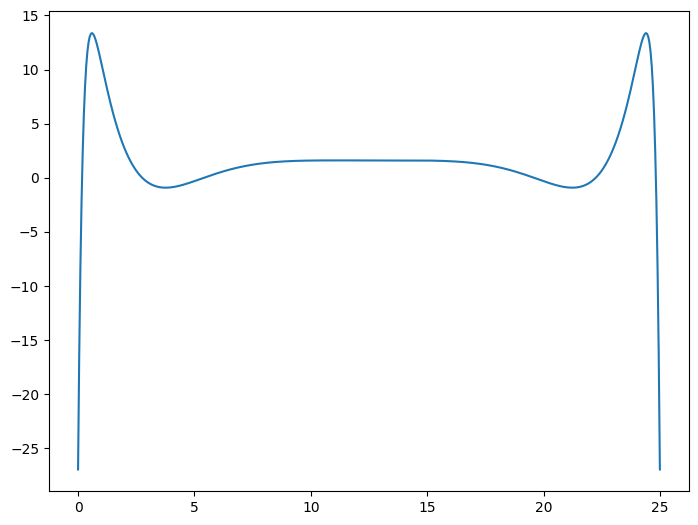

In [36]:
fig=plot.figure()
ax=fig.add_axes([0,0,1,1])
y_pos=round((nn)/2), 
y_plt=sgm_xx[:,y_pos]
ax.plot(xx,y_plt)
print("Max: ",max(y_plt))
print("Min: ",min(y_plt))

In [33]:
print("end")

end
